# Create a model for a singel asset model

In [13]:
import cira 
import pandas as pd 
from datetime import datetime
from os.path import exists

cira.auth.KEY_FILE = "../../alpc_key.json"
assert cira.auth.check_keys(), "the set keys dose not work"

SYMBOL = "MSFT"
SYM_HIST_FILE = f"./{SYMBOL}.csv"

stk = cira.Stock(SYMBOL)

if not exists(SYM_HIST_FILE): # chacheing historical data  
    start = datetime(2015, 7, 1)
    end = datetime(2023, 7, 1)
    stk.save_historical_data(SYM_HIST_FILE, start, end)

data = stk.load_historical_data(SYM_HIST_FILE)
data.head().to_dict()

{'symbol': {Timestamp('2016-01-04 05:00:00+0000', tz='UTC'): 'MSFT',
  Timestamp('2016-01-05 05:00:00+0000', tz='UTC'): 'MSFT',
  Timestamp('2016-01-06 05:00:00+0000', tz='UTC'): 'MSFT',
  Timestamp('2016-01-07 05:00:00+0000', tz='UTC'): 'MSFT',
  Timestamp('2016-01-08 05:00:00+0000', tz='UTC'): 'MSFT'},
 'open': {Timestamp('2016-01-04 05:00:00+0000', tz='UTC'): 48.18,
  Timestamp('2016-01-05 05:00:00+0000', tz='UTC'): 48.72,
  Timestamp('2016-01-06 05:00:00+0000', tz='UTC'): 48.18,
  Timestamp('2016-01-07 05:00:00+0000', tz='UTC'): 46.75,
  Timestamp('2016-01-08 05:00:00+0000', tz='UTC'): 46.45},
 'high': {Timestamp('2016-01-04 05:00:00+0000', tz='UTC'): 48.61,
  Timestamp('2016-01-05 05:00:00+0000', tz='UTC'): 49.13,
  Timestamp('2016-01-06 05:00:00+0000', tz='UTC'): 48.25,
  Timestamp('2016-01-07 05:00:00+0000', tz='UTC'): 47.44,
  Timestamp('2016-01-08 05:00:00+0000', tz='UTC'): 47.26},
 'low': {Timestamp('2016-01-04 05:00:00+0000', tz='UTC'): 47.36,
  Timestamp('2016-01-05 05:00:0

<Axes: xlabel='timestamp'>

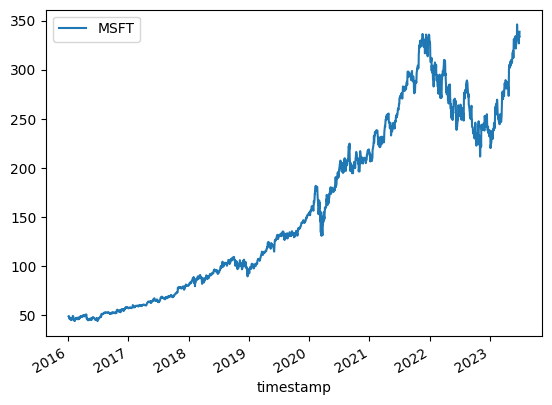

In [2]:

data.plot.line(y="close", use_index=True, label=SYMBOL)

In [3]:
split_prc = 0.8
train_data = data.iloc[:int(len(data)*split_prc)]
test_data =  data.iloc[int(len(data)*split_prc):]
print(len(data), len(train_data), len(test_data))
assert len(data) == len(train_data) + len(test_data)

1886 1508 378


## Training model

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

model = LinearRegression()

features = ['open', 'high', 'low', 'volume', 'trade_count', 'vwap']
target = "close"
X = train_data[features].values
y = train_data[target].values

model.fit(X, y)

X_test = test_data[features].values
y_test = test_data[target].values

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 1.420191802321913


## Setting up stratergy 

In [5]:
import numpy as np
from typing import List
from pandas import DataFrame

from cira.strategy import Strategy


class MyStrat(Strategy):
    def __init__(self, model=LinearRegression, risk = 0.02) -> None:
        super().__init__(name="MyStrat")
        self.model = model
        self.risk = risk
        self.sizeings = {"position_size":[]}

    def iterate(self, feature_data: DataFrame, prices: DataFrame, portfolio: np.ndarray, cash:float) -> np.ndarray:
        features = ['open', 'high', 'low', 'volume', 'trade_count', 'vwap']
        feature_data = feature_data[features]
        pred = self.model.predict(feature_data.values)
        sizeing = self.size(prices["close"][-1], pred[-1], cash, portfolio[-1])
        self.sizeings["position_size"].append(sizeing)
        return np.array([sizeing])

    def size(self, entry_price, predicted_price, cash, current_holding):
        return int(((predicted_price - entry_price)*(cash * (current_holding + 1 ) * self.risk )) / entry_price)

    
   

## Backtesting 

<Axes: xlabel='timestamp'>

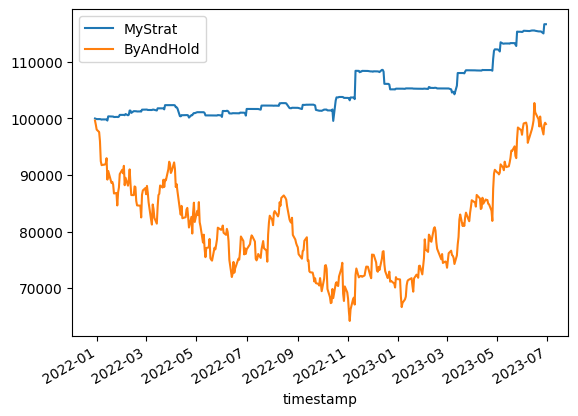

In [6]:
from cira.strategy import back_test_against_buy_and_hold as back_test

strat = MyStrat(model, risk=0.05)
prices_df = my_dataframe = pd.DataFrame(test_data[target], columns=['close'])
back_test(strat, test_data[features], prices_df, 100_000).plot()

<Axes: >

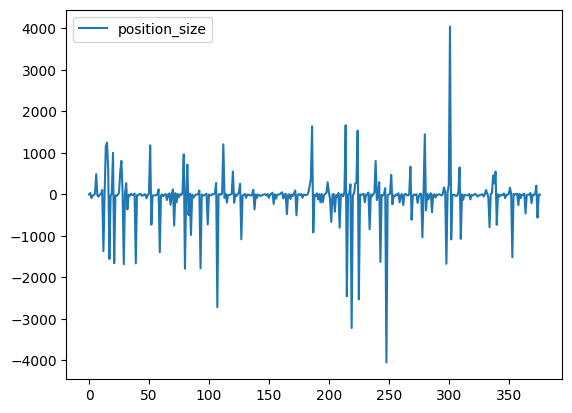

In [7]:
pd.DataFrame(strat.sizeings).plot()

## Putting the strategy into production

In [8]:
1/0 # is here to stop you from starting to the model in prod, 
    # in case you hit the run all in the notebook.

ZeroDivisionError: division by zero

In [ ]:
from cira.portfolio import Portfolio
from cira.exchange import Exchange

portfolio = Portfolio()
exchange = Exchange()


In [ ]:

from datetime import datetime 
import logging
from copy import deepcopy
from math import abs

INITAL_CAPITAL = 100_000

def get_today(offset=0) -> datetime:
    today = datetime.now()
    return datetime(int(today.year), int(today.month), int(today.day)+offset) # hack for datetime obj

def trade():
    if not exchange.is_open(): 
        print("Exchange was not open")
        return
    start = datetime(2023, 9, 15)
    end = get_today(-1)
    feature_data = stk.historical_data_df(start_date=start, end_date=end)
    prices_data = deepcopy(feature_data["close"]).to_frame()
    feature_data = feature_data.drop("symbol", axis=1, inplace=False)
    feature_data = feature_data.drop("close", axis=1, inplace=False)
    cash = portfolio.cash()
    stk_q = portfolio.get_allocation(SYMBOL)
    pos = strat.iterate(feature_data, prices_data, np.array([stk_q]), cash)
    print(datetime.now(),"new position size:",pos, f"of symbol {SYMBOL}")
    if pos < 1 and stk_q > 1: 
        if stk_q <= abs(pos):
            pos = stk_q
        stk.sell(pos)
    elif pos > 1:
        stk.buy(pos) 
    stk_q = portfolio.get_allocation(SYMBOL)
    print(f"ratio:{(portfolio.total_value())/INITAL_CAPITAL}")


In [ ]:
trade()

In [ ]:

from cira.strategy import Scheduler

scheduler = Scheduler()
scheduler.clear_all_jobs()
scheduler.add_daily_job_at(trade, "20:36")

print(scheduler.get_all_jobs())
scheduler.run() # this runs forever, it will just keep on waiting for the time to match